In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from io import BytesIO
from PIL import Image
from matplotlib.image import imread
from urllib.request import urlopen
from scipy.spatial.distance import cosine
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import Xception, VGG16, VGG19,ResNet50, MobileNetV2, DenseNet121
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation

2024-05-27 09:20:40.059199: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 09:20:40.059311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 09:20:40.202860: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv("/kaggle/input/amazon-5k-5class/amazon_5k_5class.csv").drop("Unnamed: 0", axis=1)

In [3]:
category_counts = df['categories'].value_counts()
print(df['categories'].value_counts())

categories
Cell Phones and Accessories    1000
Clothing Men                   1000
Electronics                    1000
Shoes                          1000
Watches                        1000
Name: count, dtype: int64


In [4]:
def preprocess_data(df):
    preprocessed_images = []
    preprocessed_labels = []
    i=0
    for index, row in df.iterrows():
        try:
            response = urlopen(row['imUrl'])
            img = Image.open(response)
            i=i+1
            if i % 1000 == 0:
                print(i) 
        except:
            continue
        img = img.resize((224, 224))
        img = img.convert('RGB')
        img_arr = np.array(img).astype(np.float32)
        if img_arr.shape != (224, 224, 3):
            continue
        img_arr = preprocess_input(img_arr)
        preprocessed_images.append(img_arr)
        preprocessed_labels.append(row['categories'])

    preprocessed_images = np.array(preprocessed_images)
    preprocessed_labels = np.array(preprocessed_labels)

    return preprocessed_images, preprocessed_labels

images, labels_ = preprocess_data(df)

label_encoder = LabelEncoder()
labels_ = label_encoder.fit_transform(labels_)
labels = to_categorical(labels_, num_classes=5)

1000
2000
3000
4000
5000


In [5]:
np.save("labels", labels)
np.save("images.npy", images)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

In [7]:
# Define the model
def create_model_vgg16(dropout, learning_rate):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    predictions = Dense(5, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

In [8]:
# Callbacks
early_stopping_vgg16 = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint_vgg16 = ModelCheckpoint('best_model_vgg16.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
# Create and train the model
model_vgg16 = create_model_vgg16(dropout=0.5, learning_rate=0.0001)
model_vgg16.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, 
                    callbacks=[early_stopping_vgg16, checkpoint_vgg16])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/20


2024-05-27 09:22:30.623250: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-05-27 09:22:30.623315: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-05-27 09:22:30.623329: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-05-27 09:22:30.623343: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-05-27 09:22:30.623361: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-05-27 09:22:30.623374: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-05-27 09:22:30.623384: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-05-27 09:22:30.623394: E external/local_xla/xla/se

 2/88 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.1875 - loss: 2.0140  

I0000 00:00:1716801766.392653      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7246 - loss: 0.7789

2024-05-27 09:22:53.008047: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.89842, expected 3.37692
2024-05-27 09:22:53.008104: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.13412, expected 2.61262
2024-05-27 09:22:53.008113: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 3.08377, expected 2.56227
2024-05-27 09:22:53.008121: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14: 4.1021, expected 3.5806
2024-05-27 09:22:53.008129: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 3.76539, expected 3.24388
2024-05-27 09:22:53.008136: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 4.19841, expected 3.6769
2024-05-27 09:22:53.008144: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 3.88366, expected 3.36216
2024-05-27 09:22:53.008152: E external/local_xla/xla

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.7254 - loss: 0.7766

2024-05-27 09:23:05.854308: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.05625, expected 3.15318
2024-05-27 09:23:05.854381: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.55379, expected 5.65073
2024-05-27 09:23:05.854390: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.40794, expected 5.50487
2024-05-27 09:23:05.854399: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.4763, expected 4.57323
2024-05-27 09:23:05.854406: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.64422, expected 4.74115
2024-05-27 09:23:05.854414: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.35747, expected 5.45441
2024-05-27 09:23:05.854422: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.0426, expected 5.13953
2024-05-27 09:23:05.854430: E external/local_xla/xla/serv


Epoch 1: val_accuracy improved from -inf to 0.84857, saving model to best_model_vgg16.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 54s 386ms/step - accuracy: 0.7263 - loss: 0.7743 - val_accuracy: 0.8486 - val_loss: 0.5759
Epoch 2/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9742 - loss: 0.0894
Epoch 2: val_accuracy improved from 0.84857 to 0.87857, saving model to best_model_vgg16.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.9743 - loss: 0.0891 - val_accuracy: 0.8786 - val_loss: 0.4472
Epoch 3/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9989 - loss: 0.0276
Epoch 3: val_accuracy improved from 0.87857 to 0.88571, saving model to best_model_vgg16.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.9989 - loss: 0.0276 - val_accuracy: 0.8857 - val_loss: 0.4226
Epoch 4/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9999 - loss: 0.0141
Epoch 4: val_accuracy did not improve from 0.88571
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9999 - 

In [9]:
# Load the best model
best_model_vgg16 = create_model_vgg16(dropout=0.5, learning_rate=0.0001)
best_model_vgg16.load_weights('best_model_vgg16.keras')

# Evaluate on the test set
test_loss_vgg16, test_accuracy_vgg16 = best_model_vgg16.evaluate(X_test, y_test, verbose=1)
print(f"Test loss (VGG-16): {test_loss_vgg16:.3f}, Test accuracy (VGG-16): {test_accuracy_vgg16:.3f}")

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.8503 - loss: 0.4896
Test loss (VGG-16): 0.429, Test accuracy (VGG-16): 0.862


In [10]:
# Định nghĩa hàm tạo mô hình Xception
def create_model_xception(dropout, learning_rate):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    predictions = Dense(5, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

In [11]:
# Callbacks
early_stopping_xception = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint_xception = ModelCheckpoint('best_model_xception.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Tạo và huấn luyện mô hình Xception
model_xception = create_model_xception(dropout=0.5, learning_rate=0.0005)
model_xception.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, 
                       callbacks=[early_stopping_xception, checkpoint_xception])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.5147 - loss: 1.4551
Epoch 1: val_accuracy improved from -inf to 0.63714, saving model to best_model_xception.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 43s 335ms/step - accuracy: 0.5155 - loss: 1.4515 - val_accuracy: 0.6371 - val_loss: 1.0667
Epoch 2/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7199 - loss: 0.7702
Epoch 2: val_accuracy improved from 0.63714 to 0.68143, saving model to best_model_xception.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 0.7198 - loss: 0.7701 - val_accuracy: 0.6814 - val_loss: 0.9335
Epoch 3/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7705 - loss: 0.6320
Epoch 3: val_accuracy did not improve from 0.68143
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.7705 - loss: 0.6320 - val_accuracy: 0.6714 - val_loss: 0.9155
Epoch 4/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8308 - loss: 0.4826
Epoch 4: val

In [12]:
# Tải mô hình tốt nhất
best_model_xception = create_model_xception(dropout=0.5, learning_rate=0.0001)
best_model_xception.load_weights('best_model_xception.keras')

# Đánh giá trên tập kiểm tra
test_loss_xception, test_accuracy_xception = best_model_xception.evaluate(X_test, y_test, verbose=1)
print(f"Test loss (Xception): {test_loss_xception:.3f}, Test accuracy (Xception): {test_accuracy_xception:.3f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.6805 - loss: 1.4671
Test loss (Xception): 1.179, Test accuracy (Xception): 0.690


In [13]:
# Define the model
def create_model_vgg19(dropout, learning_rate):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    predictions = Dense(5, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

In [14]:
# Callbacks
early_stopping_vgg19 = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint_vgg19 = ModelCheckpoint('best_model_vgg19.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
# Create and train the model
model_vgg19 = create_model_vgg19(dropout=0.5, learning_rate=0.0001)
model_vgg19.fit(X_train, y_train, epochs=20, batch_size=32, 
                    validation_split=0.2, callbacks=[early_stopping_vgg19, checkpoint_vgg19])

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6979 - loss: 0.8673
Epoch 1: val_accuracy improved from -inf to 0.86857, saving model to best_model_vgg19.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 0.6989 - loss: 0.8643 - val_accuracy: 0.8686 - val_loss: 0.5044
Epoch 2/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9824 - loss: 0.0793
Epoch 2: val_accuracy improved from 0.86857 to 0.87857, saving model to best_model_vgg19.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.9824 - loss: 0.0792 - val_accuracy: 0.8786 - val_loss: 0.4090
Epoch 3/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9944 - loss: 0.0319
Epoch 3: val_accuracy did not improve from 0.87857
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.9944 - loss: 0.0319 - val_accuracy: 0.8700 - val_loss: 0.4181
Epoch 4/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 0.0134
Epoch 4: val_accura

In [15]:
# Load the best model
best_model_vgg19 = create_model_vgg19(dropout=0.5, learning_rate=0.0001)
best_model_vgg19.load_weights('best_model_vgg19.keras')

# Evaluate on the test set
test_loss_vgg19, test_accuracy_vgg19 = best_model_vgg19.evaluate(X_test, y_test, verbose=1)
print(f"Test loss (VGG-19): {test_loss_vgg19:.4f}, Test accuracy (VGG-19): {test_accuracy_vgg19:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.8365 - loss: 0.4593
Test loss (VGG-19): 0.4175, Test accuracy (VGG-19): 0.8540


In [16]:
def create_model_resnet50(dropout, learning_rate):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    predictions = Dense(5, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

In [17]:
# Callbacks
early_stopping_resnet50 = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint_resnet50 = ModelCheckpoint('best_model_resnet50.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Tạo và huấn luyện mô hình ResNet50
model_resnet50 = create_model_resnet50(dropout=0.5, learning_rate=0.0005)
model_resnet50.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, 
                       callbacks=[early_stopping_resnet50, checkpoint_resnet50])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8184 - loss: 0.5915
Epoch 1: val_accuracy improved from -inf to 0.89857, saving model to best_model_resnet50.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 248ms/step - accuracy: 0.8189 - loss: 0.5895 - val_accuracy: 0.8986 - val_loss: 0.3914
Epoch 2/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9798 - loss: 0.0685
Epoch 2: val_accuracy improved from 0.89857 to 0.90000, saving model to best_model_resnet50.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9799 - loss: 0.0683 - val_accuracy: 0.9000 - val_loss: 0.3473
Epoch 3/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9980 - loss: 0.0173
Epoch 3: val_accuracy improved from 0.90000 to 0.91000, saving model to best_model_resnet50.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.9980 - loss: 0.0173 - val_accuracy: 0.9100 - val_loss: 0.2924
Epoch 4/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step -

In [18]:
# Tải mô hình tốt nhất
best_model_resnet50 = create_model_resnet50(dropout=0.5, learning_rate=0.0001)
best_model_resnet50.load_weights('best_model_resnet50.keras')

# Đánh giá trên tập kiểm tra
test_loss_resnet50, test_accuracy_resnet50 = best_model_resnet50.evaluate(X_test, y_test, verbose=1)
print(f"Test loss (ResNet50): {test_loss_resnet50:.3f}, Test accuracy (ResNet50): {test_accuracy_resnet50:.3f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.8846 - loss: 0.3905
Test loss (ResNet50): 0.315, Test accuracy (ResNet50): 0.908


In [19]:
def create_model_mobilenetv2(dropout, learning_rate):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    predictions = Dense(5, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

In [20]:
# Callbacks
early_stopping_mobilenetv2 = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint_mobilenetv2 = ModelCheckpoint('best_model_mobilenetv2.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Tạo và huấn luyện mô hình MobileNetV2
model_mobilenetv2 = create_model_mobilenetv2(dropout=0.5, learning_rate=0.0005)
model_mobilenetv2.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, 
                       callbacks=[early_stopping_mobilenetv2, checkpoint_mobilenetv2])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7164 - loss: 0.9135
Epoch 1: val_accuracy improved from -inf to 0.83000, saving model to best_model_mobilenetv2.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step - accuracy: 0.7172 - loss: 0.9104 - val_accuracy: 0.8300 - val_loss: 0.5549
Epoch 2/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9597 - loss: 0.1441
Epoch 2: val_accuracy did not improve from 0.83000
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9597 - loss: 0.1439 - val_accuracy: 0.8157 - val_loss: 0.5960
Epoch 3/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9907 - loss: 0.0492
Epoch 3: val_accuracy improved from 0.83000 to 0.83714, saving model to best_model_mobilenetv2.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9908 - loss: 0.0490 - val_accuracy: 0.8371 - val_loss: 0.5583
Epoch 4/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9983 - loss: 0.0137
Epoch 4: va

In [21]:
# Tải mô hình tốt nhất
best_model_mobilenetv2 = create_model_mobilenetv2(dropout=0.5, learning_rate=0.0001)
best_model_mobilenetv2.load_weights('best_model_mobilenetv2.keras')

# Đánh giá trên tập kiểm tra
test_loss_mobilenetv2, test_accuracy_mobilenetv2 = best_model_mobilenetv2.evaluate(X_test, y_test, verbose=1)
print(f"Test loss (MobileNetV2): {test_loss_mobilenetv2:.3f}, Test accuracy (MobileNetV2): {test_accuracy_mobilenetv2:.3f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.8264 - loss: 0.6894
Test loss (MobileNetV2): 0.599, Test accuracy (MobileNetV2): 0.848


In [22]:
# Định nghĩa hàm tạo mô hình DenseNet121
def create_model_densenet121(dropout, learning_rate):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    predictions = Dense(5, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

In [23]:
# Callbacks
early_stopping_densenet121 = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint_densenet121 = ModelCheckpoint('best_model_densenet121.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Tạo và huấn luyện mô hình DenseNet121
model_densenet121 = create_model_densenet121(dropout=0.5, learning_rate=0.0005)
model_densenet121.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, 
                       callbacks=[early_stopping_densenet121, checkpoint_densenet121])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.5981 - loss: 1.2034
Epoch 1: val_accuracy improved from -inf to 0.73286, saving model to best_model_densenet121.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 79s 552ms/step - accuracy: 0.5990 - loss: 1.2001 - val_accuracy: 0.7329 - val_loss: 0.8372
Epoch 2/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8285 - loss: 0.4807
Epoch 2: val_accuracy improved from 0.73286 to 0.74000, saving model to best_model_densenet121.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.8284 - loss: 0.4808 - val_accuracy: 0.7400 - val_loss: 0.7347
Epoch 3/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8729 - loss: 0.3787
Epoch 3: val_accuracy did not improve from 0.74000
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.8729 - loss: 0.3783 - val_accuracy: 0.7143 - val_loss: 0.8237
Epoch 4/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9283 - loss: 0.2103
Epoch 4:

In [24]:
# Tải mô hình tốt nhất
best_model_densenet121 = create_model_densenet121(dropout=0.5, learning_rate=0.0001)
best_model_densenet121.load_weights('best_model_densenet121.keras')

# Đánh giá trên tập kiểm tra
test_loss_densenet121, test_accuracy_densenet121 = best_model_densenet121.evaluate(X_test, y_test, verbose=1)
print(f"Test loss (DenseNet121): {test_loss_densenet121:.3f}, Test accuracy (DenseNet121): {test_accuracy_densenet121:.3f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - accuracy: 0.7595 - loss: 0.7657
Test loss (DenseNet121): 0.710, Test accuracy (DenseNet121): 0.771


# END

In [25]:
# Lưu mô hình
best_model_resnet50.save('model_resnet50.h5')

In [26]:
y_pred = best_model_resnet50.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step


In [27]:
report = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_)
print(report)

                             precision    recall  f1-score   support

Cell Phones and Accessories       0.83      0.85      0.84       316
               Clothing Men       0.92      0.92      0.92       309
                Electronics       0.85      0.84      0.85       284
                      Shoes       0.96      0.95      0.95       301
                    Watches       0.99      0.98      0.98       290

                   accuracy                           0.91      1500
                  macro avg       0.91      0.91      0.91      1500
               weighted avg       0.91      0.91      0.91      1500



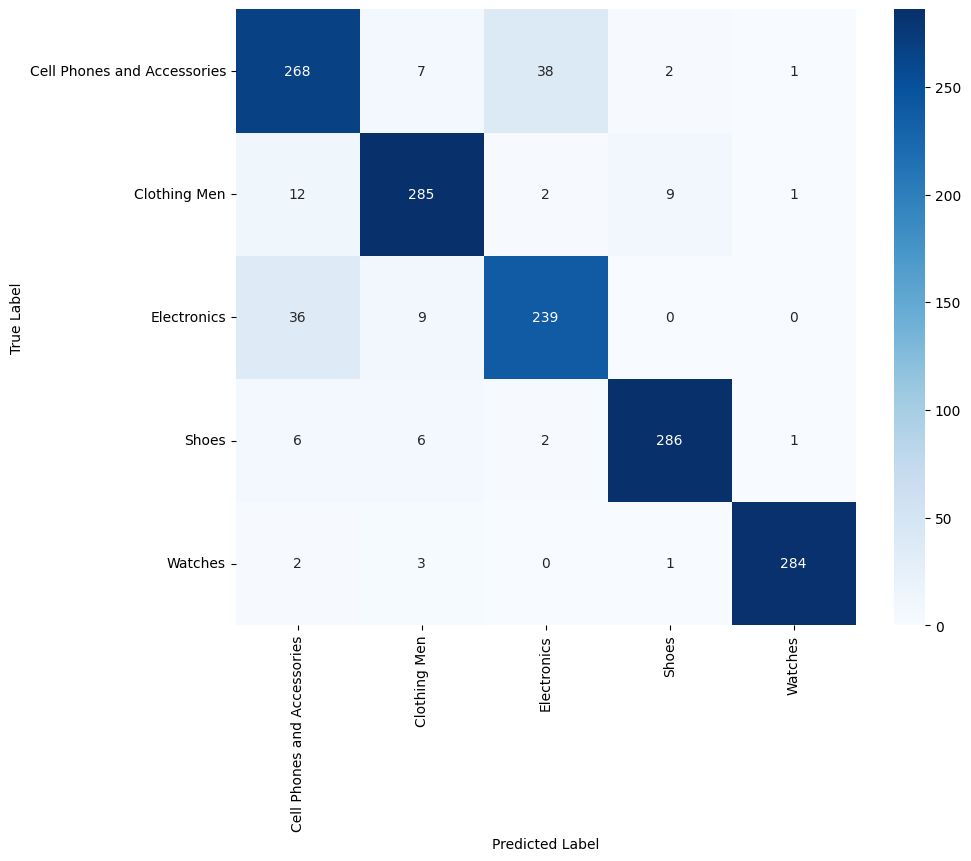

In [28]:
# Tạo ma trận nhầm lẫn với nhãn thực
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Số lượng ví dụ bị phân loại sai: 138


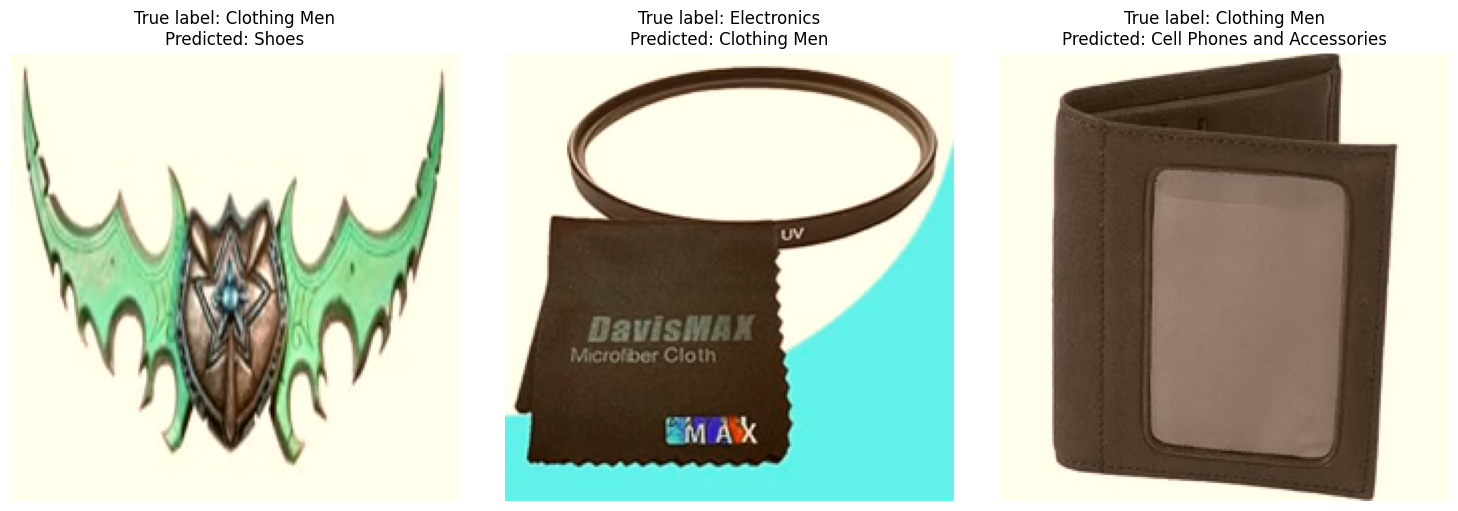

In [29]:
misclassified_indices = np.where(y_pred_classes != y_true)[0]
num_misclassified = len(misclassified_indices)
print(f"Số lượng ví dụ bị phân loại sai: {num_misclassified}")

num_examples = 3

fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))

for i in range(min(num_examples, num_misclassified)):
    index = misclassified_indices[i]
    img = X_test[index]
    
    img = img + [123.68, 116.779, 103.939]
    img = np.clip(img, 0, 255).astype(np.uint8)
    
    ax = axes[i]
    ax.imshow(img)
    true_label = label_encoder.inverse_transform([y_true[index]])[0]
    predicted_label = label_encoder.inverse_transform([y_pred_classes[index]])[0]
    ax.set_title(f"True label: {true_label}\nPredicted: {predicted_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()